In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

        GSPs GSPGroup                                           geometry
0       NETS       _N  MULTIPOLYGON (((243392.63 589698.709, 255939.4...
1       CHAP       _N  MULTIPOLYGON (((331236.338 565048.182, 331214....
2     BISW_1       _E  MULTIPOLYGON (((311775.048 281560.56, 311722.7...
3       PORD       _N  MULTIPOLYGON (((258665.362 665428.688, 258649....
4     BROR_P       _P  MULTIPOLYGON (((309710.615 919660.326, 309641....
..       ...      ...                                                ...
95    CITR_1       _C  MULTIPOLYGON (((530111.178 183348.146, 530148 ...
96    BRIM_1       _C  MULTIPOLYGON (((547386.593 190446.597, 547348....
97  BLYTH132       _F  MULTIPOLYGON (((414434.071 640669.426, 414290....
98     INDQ1       _L  MULTIPOLYGON (((212020.975 50266.911, 212007.0...
99      SASA       _D  MULTIPOLYGON (((298387.958 357188.398, 294269....

[100 rows x 3 columns]


<Axes: >

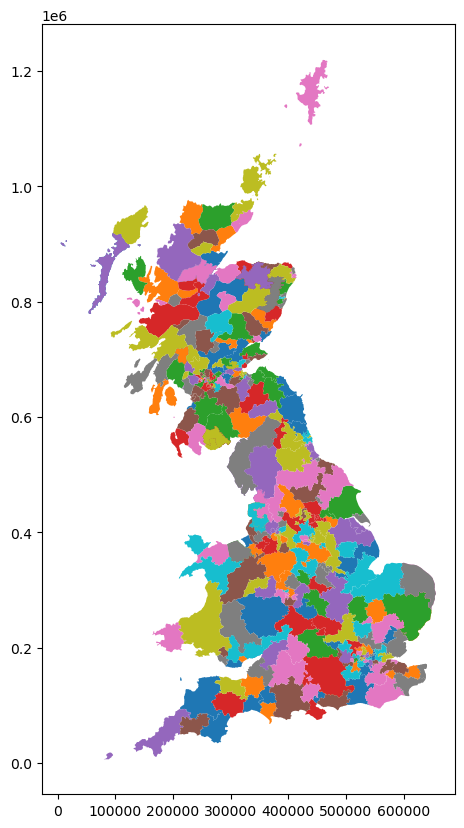

In [3]:
# import the shape files of the FLOPs and plot them

df_gsp = gpd.read_file("GSP_regions_27700_20250109.geojson")
print(df_gsp.head(100))

df_gsp_dissolved = df_gsp.dissolve(by="GSPs") # or by GSPGroup

fig,ax = plt.subplots(figsize=(20,10))
df_gsp_dissolved.plot(column=df_gsp_dissolved.index, legend=False, ax=ax)

In [4]:
# import the demand data for the FLOPs and merge to get Major FLOPs

df_flop = pd.read_csv("FES_2030_demand.csv")
#print(df_flop.head())
print(len(df_flop))

# Merge the GeoDataFrame with the mean capacity factors DataFrame
df_merged = df_flop.merge(df_gsp, left_on="Elexon ID", right_on = "GSPs", how="left")
print(df_merged.head())


539
  Elexon ID             Name Minor FLOP Major FLOP     P(Gross)  \
0       NaN              NaN        NaN        NaN  Demand (MW)   
1     ABHA1            Abham         F6          F        336.9   
2    ABNE_P        Abernethy         T4          T         38.6   
3    ABTH_1         Aberthaw         H2          H        181.5   
4    ACTL_2  Acton Lane 66kV         A7          A         25.7   

         Q Gross          Q net     Embedded Storage       Embedded Solar  \
0  Demand (MVAR)  Demand (MVAR)  Total Capacity (MW)  Total Capacity (MW)   
1            0.9          -20.9                191.3                389.6   
2           -0.7             -2                    1                 42.6   
3            8.7          -32.7                  2.4                129.3   
4           -2.2           -2.7                  0.6                 12.6   

         Embedded Wind       Embedded Hydro       Embedded Other    GSPs  \
0  Total Capacity (MW)  Total Capacity (MW)  Total Cap

In [5]:
# Add the demand FLOPs together, then separately dissolve geometries by FLOP, then merge two dataframes

# Select which columns to keep
df_filtered = df_merged[["Major FLOP", "P(Gross)", "Q Gross", "Embedded Solar", "Embedded Wind", "Embedded Storage"]]
#print(df_filtered.head(20))

# Convert P(Gross) to numeric, forcing errors to NaN if needed
df_filtered["P(Gross)"] = pd.to_numeric(df_filtered["P(Gross)"], errors="coerce")
df_filtered["Q Gross"] = pd.to_numeric(df_filtered["Q Gross"], errors="coerce")
df_filtered["Embedded Solar"] = pd.to_numeric(df_filtered["Embedded Solar"], errors="coerce")
df_filtered["Embedded Wind"] = pd.to_numeric(df_filtered["Embedded Wind"], errors="coerce")
df_filtered["Embedded Storage"] = pd.to_numeric(df_filtered["Embedded Storage"], errors="coerce")

# sum everything by Major FLOP
df_demand = df_filtered.groupby("Major FLOP").sum().reset_index()
print(df_demand)

   Major FLOP  P(Gross)  Q Gross  Embedded Solar  Embedded Wind  \
0           A   10131.5   1260.2          1153.3            1.1   
1           B    3551.3    292.5          2013.1          109.8   
2           C    2179.3    184.7          1772.5          301.2   
3           D    2643.9     36.6          1810.2           43.6   
4           E    1269.3     29.1          1914.7            4.5   
5           F    1649.7     61.3          2298.6          427.2   
6           G    2927.8    403.9          3688.5           86.7   
7           H    3180.5    415.3          2539.5         1172.3   
8           J    4005.3    176.5          5105.8         1023.0   
9           K     601.2     51.9          1432.4          244.7   
10          L    8643.7    790.1          4197.3          328.4   
11          M     911.7     11.2           780.2         1060.7   
12          N    6375.2    299.4          1151.8          349.1   
13          P    6252.7    274.1          2355.2         1035.

C:\Users\eddie\AppData\Local\Temp\ipykernel_14484\1037821794.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["P(Gross)"] = pd.to_numeric(df_filtered["P(Gross)"], errors="coerce")
C:\Users\eddie\AppData\Local\Temp\ipykernel_14484\1037821794.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Q Gross"] = pd.to_numeric(df_filtered["Q Gross"], errors="coerce")
C:\Users\eddie\AppData\Local\Temp\ipykernel_14484\1037821794.py:10: SettingWithCopyWarning: 
A value is trying to be set on 

In [6]:
# Dissolve geometries by Major FLOP

# Select which columns to keep for the dissolve
df_filtered_geometry = df_merged[["Major FLOP", "geometry"]]
print(df_filtered_geometry.head(20))

# create a GeoDataFrame
gdf_filtered_geometry = gpd.GeoDataFrame(df_filtered_geometry, geometry="geometry")

# Dissolve geometries by Major FLOP
dissolved = gdf_filtered_geometry.dissolve(by="Major FLOP", aggfunc = "sum").reset_index()
print(dissolved.head(18))

   Major FLOP                                           geometry
0         NaN                                               None
1           F  MULTIPOLYGON (((300127.725 79687.548, 299459.2...
2           T  MULTIPOLYGON (((301732.526 695142.713, 301402 ...
3           H  MULTIPOLYGON (((322230 165160, 322400 165180, ...
4           A  MULTIPOLYGON (((513402.64 179723.834, 513305.8...
5           A  MULTIPOLYGON (((523834.573 182523.86, 523814.2...
6           T  MULTIPOLYGON (((273931.039 886100.918, 273920....
7           H  MULTIPOLYGON (((354474.988 188843.797, 353929....
8           F  MULTIPOLYGON (((212061.466 94143.068, 212217.6...
9           A  MULTIPOLYGON (((493472.077 207138.588, 493048....
10          T  MULTIPOLYGON (((365872.608 748762.403, 366110....
11          T  MULTIPOLYGON (((203333.965 710410.024, 203347....
12          T  MULTIPOLYGON (((123886.162 899272.979, 123832....
13          E  MULTIPOLYGON (((350404.641 120342.602, 350369....
14          E  MULTIPOLYG

In [ ]:
# Merge the new geometry with the demand based on Major FLOP
df_final = dissolved.merge(df_demand, on="Major FLOP", how="left")
print(df_final.head(20))

# print sum of P(Gross)
total_demand = df_final["P(Gross)"].sum()
print("Total Demand (MW):", total_demand)

# save as csv
#df_final.to_csv("FLOP_demand_2030.csv", index=False)

   Major FLOP                                           geometry  P(Gross)  \
0           A  MULTIPOLYGON (((499272 142548, 499230 142600, ...   10131.5   
1           B  MULTIPOLYGON (((449470.92 102396.844, 449438.2...    3551.3   
2           C  MULTIPOLYGON (((532060.114 143491.058, 531951....    2179.3   
3           D  MULTIPOLYGON (((493191.034 206824.291, 493032....    2643.9   
4           E  MULTIPOLYGON (((347800.464 88920.721, 346449.7...    1269.3   
5           F  MULTIPOLYGON (((86209.974 11377.099, 86128.516...    1649.7   
6           G  MULTIPOLYGON (((365026.998 134319.801, 365025....    2927.8   
7           H  MULTIPOLYGON (((319884.02 172587.613, 319827.4...    3180.5   
8           J  MULTIPOLYGON (((567823.55 206262.51, 567801.87...    4005.3   
9           K  MULTIPOLYGON (((464051.666 344196.739, 464060....     601.2   
10          L  MULTIPOLYGON (((340334.554 225744.235, 340318....    8643.7   
11          M  POLYGON ((340687.608 355801.863, 341127.779 35...

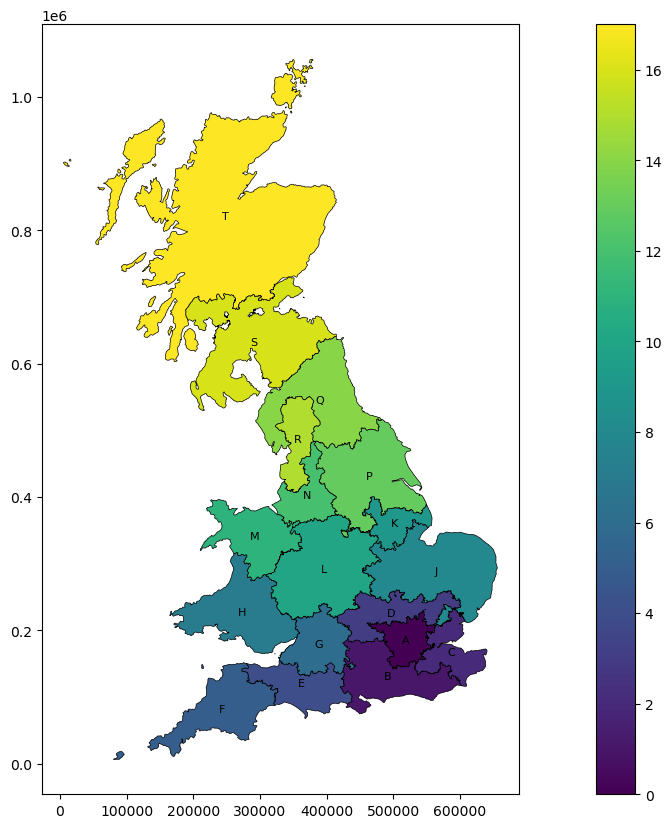

In [8]:
# plot a map of the FLOPS

ax = df_final.plot(column=dissolved.index, legend=True,figsize=(20,10), edgecolor="black", linewidth=0.5, label="Major FLOP")
# label each FLOP with its name
for x, y, label in zip(df_final.geometry.centroid.x, df_final.geometry.centroid.y, df_final["Major FLOP"]):
    ax.text(x, y, label, fontsize=8, ha='center', va='center')



In [18]:
# calculate the proportion of renewables in each FLOP

# import data file
df_renewables = pd.read_csv("FLOP_power_generation_2025.csv")
#print(df_renewables.head())

# select to keep only Major FLOP, Solar, Wind
df_renewables_filtered = df_renewables[["Major FLOP", "Embedded Solar", "Embedded Wind", "Embedded Storage","Capacity (MW)"]]

# merge solar/wind/capacity into one column called Renewables ignoring NaN values
df_renewables_filtered["Renewables"] = df_renewables_filtered["Embedded Solar"].fillna(0) + df_renewables_filtered["Embedded Wind"].fillna(0) + df_renewables_filtered["Capacity (MW)"].fillna(0)
#print(df_renewables_filtered.head(20))

# calculate proportion of renewables (eg FLOP A/ Total Demand)
df_renewables_filtered["Proportion Renewables"] = df_renewables_filtered["Renewables"] / df_renewables_filtered["Renewables"].sum()
# only show Major FLOPs, renewables and proportion renewables
df_renewables_filtered = df_renewables_filtered[["Major FLOP", "Renewables", "Proportion Renewables","Embedded Storage"]]
print(df_renewables_filtered.head(20))


# sum proportion of renewables
total_renewables = df_renewables_filtered["Proportion Renewables"].sum()
print("Total Renewables (MW):", total_renewables)

   Major FLOP  Renewables  Proportion Renewables  Embedded Storage
0           A       676.6               0.011879             179.2
1           B      1842.2               0.032344             167.9
2           C      2803.3               0.049218             430.6
3           D      1308.6               0.022975             392.0
4           E      1260.6               0.022132             113.9
5           F      1928.2               0.033854             279.8
6           G      2723.7               0.047820             707.4
7           H      2858.1               0.050180             193.4
8           J     11110.6               0.195070             507.4
9           K      2220.3               0.038982             153.4
10          L      3213.7               0.056423             821.9
11          M      1893.1               0.033237               5.1
12          N      1281.0               0.022491             441.6
13          P      3660.1               0.064261             7

C:\Users\eddie\AppData\Local\Temp\ipykernel_14484\2659161594.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_renewables_filtered["Renewables"] = df_renewables_filtered["Embedded Solar"].fillna(0) + df_renewables_filtered["Embedded Wind"].fillna(0) + df_renewables_filtered["Capacity (MW)"].fillna(0)
C:\Users\eddie\AppData\Local\Temp\ipykernel_14484\2659161594.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_renewables_filtered["Proportion Renewables"] = df_renewables_filtered["Renewables"] / d

In [19]:
# I am adding 4588.2 MW of renewables capacity in total across all FLOPs, keeping geospatial distribution consistent
# Additional renewables capacity per FLOP is calculated as:
df_renewables_filtered["Additional Renewables Capacity (MW)"] = df_renewables_filtered["Proportion Renewables"] * 4588.2
print(df_renewables_filtered[["Major FLOP", "Additional Renewables Capacity (MW)"]])


   Major FLOP  Additional Renewables Capacity (MW)
0           A                            54.503760
1           B                           148.399094
2           C                           225.820856
3           D                           105.414751
4           E                           101.548094
5           F                           155.326855
6           G                           219.408649
7           H                           230.235290
8           J                           895.018442
9           K                           178.857078
10          L                           258.880778
11          M                           152.499362
12          N                           103.191423
13          P                           294.840693
14          Q                           577.243637
15          R                            25.592440
16          S                           458.666139
17          T                           402.752660


In [ ]:
# add the additional renewables capacity to total_renewables in a new column (including embedded storage)
df_renewables_filtered["Total_Renewable_Generation_MW"] = df_renewables_filtered["Renewables"] + df_renewables_filtered["Additional Renewables Capacity (MW)"]+ df_renewables_filtered["Embedded Storage"] 
print(df_renewables_filtered[["Major FLOP", "Renewables","Additional Renewables Capacity (MW)","Total_Renewable_Generation_MW"]])

# save as csv
#df_renewables_filtered.to_csv("FLOP_power_generation_2030.csv", index=False)


   Major FLOP  Renewables  Additional Renewables Capacity (MW)  \
0           A       676.6                            54.503760   
1           B      1842.2                           148.399094   
2           C      2803.3                           225.820856   
3           D      1308.6                           105.414751   
4           E      1260.6                           101.548094   
5           F      1928.2                           155.326855   
6           G      2723.7                           219.408649   
7           H      2858.1                           230.235290   
8           J     11110.6                           895.018442   
9           K      2220.3                           178.857078   
10          L      3213.7                           258.880778   
11          M      1893.1                           152.499362   
12          N      1281.0                           103.191423   
13          P      3660.1                           294.840693   
14        